## Testing out notebook interactivity

In [1]:

# import packages for data manipulation
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gpd

# packages for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

# set Seaborn context/style
sns.set_context(context='notebook')
sns.set_style('darkgrid')

# for interactivity
from ipywidgets import *

In [2]:
# database connection
DB = 'template_postgis'
USER = 'postgres'
HOST = 'localhost'
PORT = '5432'
PW = 'postgres'

DB_CONNECTION_STRING = 'postgresql://{username}:{password}@{host}:{port}/{database}'.format(
username=USER, password=PW, host=HOST, port=PORT, database=DB)

engine = create_engine(DB_CONNECTION_STRING)

In [3]:
# function to get data - cbsafp = '28140' is KCMO metro area
def getWAC(seg='s000', jt='jt01', years=xrange(2002,2016), cbsafp = '28140'):
    # to pull data from database
    DFs = []
    # get data
    for year in years:
        qry = """
        SELECT *, left(w_geocode, 5) countyfp, {YR} AS year FROM mo_wac_{SEG}_{JT}_{YR}
        WHERE left(w_geocode, 5) 
        IN (SELECT geoid FROM tl_2016_us_county WHERE cbsafp = '{CBSA}')
        """.format(SEG=seg, JT=jt, YR=year, CBSA=cbsafp)
        df = pd.read_sql(qry, engine)
#         df.drop(columns='createdate', inplace=True)
#         df['year'] = year
        DFs.append(df)
    # combine DFs into single dataframe
    df = pd.concat(DFs)
    return(df)

In [4]:
df = getWAC(years=xrange(2004,2014))
df.year.value_counts()

2006    10502
2005    10390
2004    10320
2008    10267
2007    10240
2009    10225
2010    10110
2013     8587
2012     8494
2011     8137
Name: year, dtype: int64

/Users/crh278/anaconda3/envs/ada-env/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


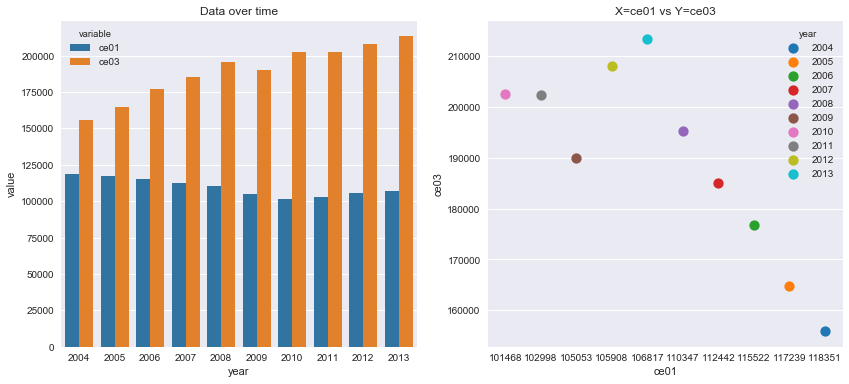

In [5]:
# test graphs
col1 = 'ce01'
col2 = 'ce03'

dfpl = df.groupby('year')[col1, col2].sum().reset_index()
dfpl2 = pd.melt(dfpl, id_vars='year', value_vars=[col1, col2])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

sns.barplot('year', 'value', 'variable', data=dfpl2, ax=ax1)
ax1.set_title('Data over time')

# ax2.set_aspect('equal', 'datalim')
sns.pointplot(col1, col2, data=dfpl, hue='year', ax=ax2)
ax2.set_title('X={} vs Y={}'.format(col1, col2))

f.show()

added following CRS to database to align with KCMO standard, from http://spatialreference.org/ref/esri/102698/postgis/

> INSERT into spatial_ref_sys (srid, auth_name, auth_srid, proj4text, srtext) values ( 9102698, 'esri', 102698, '+proj=tmerc +lat_0=36.16666666666666 +lon_0=-94.5 +k=0.9999411764705882 +x_0=850000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs ', 'PROJCS["NAD_1983_StatePlane_Missouri_West_FIPS_2403_Feet",GEOGCS["GCS_North_American_1983",DATUM["North_American_Datum_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",2788708.333333333],PARAMETER["False_Northing",0],PARAMETER["Central_Meridian",-94.5],PARAMETER["Scale_Factor",0.9999411764705882],PARAMETER["Latitude_Of_Origin",36.16666666666666],UNIT["Foot_US",0.30480060960121924],AUTHORITY["EPSG","102698"]]');

In [6]:
# get counties for map

qry = """
SELECT geoid, 
    ST_Transform(geom, 102698) geom 
FROM tl_2016_us_county 
WHERE cbsafp = '{CBSA}' AND statefp = '29'
""".format(CBSA='28140')

counties = gpd.read_postgis(qry, engine, geom_col='geom')

In [7]:
def plot_cnty(yr, col): 
    f, ax = plt.subplots(1, figsize=(12,8))
    # get specified data summarized by county
    cnty_df = pd.merge(counties.loc[:,('geoid', 'geom')],
                       #
                    df[df['year']==yr].groupby('countyfp')[col].sum().reset_index(), 
                    left_on='geoid', right_on='countyfp')
    cnty_df.plot(col, ax=ax, legend=True) 

interact(plot_cnty,yr=df['year'].unique(), col=df.columns.tolist()[1:])

interactive(children=(Dropdown(description=u'yr', options=(2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013), value=2004), Dropdown(description=u'col', options=(u'c000', u'ca01', u'ca02', u'ca03', u'ce01', u'ce02', u'ce03', u'cns01', u'cns02', u'cns03', u'cns04', u'cns05', u'cns06', u'cns07', u'cns08', u'cns09', u'cns10', u'cns11', u'cns12', u'cns13', u'cns14', u'cns15', u'cns16', u'cns17', u'cns18', u'cns19', u'cns20', u'cr01', u'cr02', u'cr03', u'cr04', u'cr05', u'cr07', u'ct01', u'ct02', u'cd01', u'cd02', u'cd03', u'cd04', u'cs01', u'cs02', u'cfa01', u'cfa02', u'cfa03', u'cfa04', u'cfa05', u'cfs01', u'cfs02', u'cfs03', u'cfs04', u'cfs05', u'createdate', u'countyfp', u'year'), value=u'c000'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_cnty>

![county map example](lodes_example_county_map.png)

In [8]:
# prep data
dfpl = df.groupby('year')[df.columns.tolist()[1:-3]].sum().reset_index()
dfpl2 = pd.melt(dfpl, id_vars='year', value_vars=df.columns.tolist()[1:-3])

In [9]:
## compare two columns in two side by side graphs: bar chart over time and scatter plot of col1 v col2 over time
def compare_cols(col1, col2):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

    sns.barplot('year', 'value', 'variable', data=dfpl2[dfpl2['variable'].isin([col2, col1])], ax=ax1)
    ax1.set_title('{} and {}'.format(col1, col2))

    sns.pointplot(col1, col2, data=dfpl, ax=ax2, linestyles='--') #hue='year', 
    ax2.set_title('X={} vs Y={}'.format(col1, col2))
#     ax2.set_aspect('equal', 'datalim')
    
    for c in ax2.collections:
        for i, of in enumerate(c.get_offsets()):
            ax2.annotate(dfpl['year'][i], (of[0]+0.2, of[1]),
                         horizontalalignment='left', size='medium', color='black', 
                         weight='semibold')
    # return f? or plt?
    f.suptitle('Comparing {} and {} over time'.format(col1, col2))
#     return(plt)

interact(compare_cols, col1=df.columns.tolist()[1:-2], col2=df.columns.tolist()[1:-2])

interactive(children=(Dropdown(description=u'col1', options=(u'c000', u'ca01', u'ca02', u'ca03', u'ce01', u'ce02', u'ce03', u'cns01', u'cns02', u'cns03', u'cns04', u'cns05', u'cns06', u'cns07', u'cns08', u'cns09', u'cns10', u'cns11', u'cns12', u'cns13', u'cns14', u'cns15', u'cns16', u'cns17', u'cns18', u'cns19', u'cns20', u'cr01', u'cr02', u'cr03', u'cr04', u'cr05', u'cr07', u'ct01', u'ct02', u'cd01', u'cd02', u'cd03', u'cd04', u'cs01', u'cs02', u'cfa01', u'cfa02', u'cfa03', u'cfa04', u'cfa05', u'cfs01', u'cfs02', u'cfs03', u'cfs04', u'cfs05', u'createdate'), value=u'c000'), Dropdown(description=u'col2', options=(u'c000', u'ca01', u'ca02', u'ca03', u'ce01', u'ce02', u'ce03', u'cns01', u'cns02', u'cns03', u'cns04', u'cns05', u'cns06', u'cns07', u'cns08', u'cns09', u'cns10', u'cns11', u'cns12', u'cns13', u'cns14', u'cns15', u'cns16', u'cns17', u'cns18', u'cns19', u'cns20', u'cr01', u'cr02', u'cr03', u'cr04', u'cr05', u'cr07', u'ct01', u'ct02', u'cd01', u'cd02', u'cd03', u'cd04', u'cs01', u'cs02', u'cfa01', u'cfa02', u'cfa03', u'cfa04', u'cfa05', u'cfs01', u'cfs02', u'cfs03', u'cfs04', u'cfs05', u'createdate'), value=u'c000'), Output()), _dom_classes=('widget-interact',))

<function __main__.compare_cols>

![Column compare example](lodes_example_column_compare.png)